In [42]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix, classification_report
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

# Original Dataset

In [43]:
# Load the data
df = pd.read_csv('../../data/processed/heart_se.csv')
# Split the data into features and target variable
X = df.drop(['target','index'], axis=1)
y = df['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# Define the objective function to be optimized
def objective(trial):
    # Suggest values for the hyperparameters
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'])
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])

    # Handle invalid combinations by returning a low score
    if penalty == 'l1' and solver not in ['liblinear', 'saga']:
        return 0.0
    if penalty == 'elasticnet' and solver != 'saga':
        return 0.0
    if penalty == 'l2' and solver == 'liblinear':
        dual = trial.suggest_categorical('dual', [True, False])
    else:
        dual = False

    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0) if penalty == 'elasticnet' else None
    tol = trial.suggest_float('tol', 1e-6, 1e-3, log=True)
    C = trial.suggest_float('C', 0.01, 10.0, log=True)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    intercept_scaling = trial.suggest_float('intercept_scaling', 0.1, 2.0) if solver == 'liblinear' else 1.0
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    warm_start = trial.suggest_categorical('warm_start', [True, False])

    # Create a Logistic Regression classifier with the suggested hyperparameters
    logreg = LogisticRegression(
        penalty=penalty,
        dual=dual,
        tol=tol,
        C=C,
        fit_intercept=fit_intercept,
        intercept_scaling=intercept_scaling,
        class_weight=class_weight,
        random_state=42,
        solver=solver,
        max_iter=max_iter,
        warm_start=warm_start,
        l1_ratio=l1_ratio,
    )

    # Use cross-validation to evaluate the model
    score = cross_val_score(logreg, X_train, y_train, n_jobs=1, cv=3)
    accuracy = score.mean()

    return accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Train the final model with the best hyperparameters
logreg = LogisticRegression(**best_params)
logreg.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = logreg.predict(X_test)

# Evaluate the final model
accuracy = logreg.score(X_test, y_test)
print(f"Test set accuracy: {accuracy:.2f}")

[I 2024-08-29 15:04:16,222] A new study created in memory with name: no-name-4ce0c434-45d1-4fbf-873d-ff7b18eedfa6
[I 2024-08-29 15:04:16,265] Trial 0 finished with value: 0.8348765432098766 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'tol': 1.970417638756097e-06, 'C': 0.11437385288897857, 'fit_intercept': False, 'class_weight': 'balanced', 'max_iter': 314, 'warm_start': True}. Best is trial 0 with value: 0.8348765432098766.
[I 2024-08-29 15:04:16,296] Trial 1 finished with value: 0.797685185185185 and parameters: {'solver': 'saga', 'penalty': 'l1', 'tol': 1.959639915749184e-05, 'C': 0.8422797546605441, 'fit_intercept': True, 'class_weight': 'balanced', 'max_iter': 594, 'warm_start': False}. Best is trial 0 with value: 0.8348765432098766.
[I 2024-08-29 15:04:16,311] Trial 2 finished with value: 0.8058641975308642 and parameters: {'solver': 'sag', 'penalty': 'l2', 'tol': 4.324333229036883e-06, 'C': 3.5949998755457067, 'fit_intercept': True, 'class_weight': None, 'max_iter': 859,

Best hyperparameters: {'solver': 'sag', 'penalty': 'l2', 'tol': 3.6149093733787146e-05, 'C': 0.03868116734633665, 'fit_intercept': False, 'class_weight': 'balanced', 'max_iter': 654, 'warm_start': False}
Test set accuracy: 0.85


In [45]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice

# Plot the optimization history
opt_history = plot_optimization_history(study)
opt_history.show()


In [46]:
# Plot the hyperparameter importances
param_importance = plot_param_importances(study, params=list(study.best_params.keys()))
param_importance.show()

In [47]:
# Plot including all hyperparameters, even if some dominate
parallel_coordinate = plot_parallel_coordinate(study, params=study.best_params.keys())
parallel_coordinate.show()

In [48]:

# Plot the slice plot for each hyperparameter
slice_plot = plot_slice(study)
slice_plot.show()

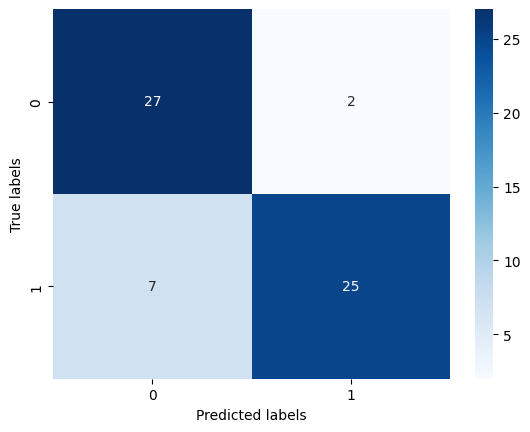

In [49]:
#test the model with the best hyperparameters
y_pred = logreg.predict(X_test)
#plot the confusion matrix 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()



In [50]:
# Generate a classification report
cls_report = classification_report(y_test, y_pred)
print(cls_report)

              precision    recall  f1-score   support

           0       0.79      0.93      0.86        29
           1       0.93      0.78      0.85        32

    accuracy                           0.85        61
   macro avg       0.86      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61



# Rebalanced

In [51]:
# Load the data
df_train = pd.read_csv('../../data/processed/resampled/heart_resampled_train_se.csv')
df_test = pd.read_csv('../../data/processed/resampled/heart_resampled_test_se.csv')

# Split the data into features and target variable
X_train = df_train.drop(['target','index'], axis=1)
y_train = df_train['target']
X_test = df_test.drop(['target','index'], axis=1)
y_test = df_test['target']

In [52]:
def objective(trial):
    # Suggest values for the hyperparameters
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'])
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])

    # Handle invalid combinations by returning a low score
    if penalty == 'l1' and solver not in ['liblinear', 'saga']:
        return 0.0
    if penalty == 'elasticnet' and solver != 'saga':
        return 0.0
    if penalty == 'l2' and solver == 'liblinear':
        dual = trial.suggest_categorical('dual', [True, False])
    else:
        dual = False

    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0) if penalty == 'elasticnet' else None
    tol = trial.suggest_float('tol', 1e-6, 1e-3, log=True)
    C = trial.suggest_float('C', 0.01, 10.0, log=True)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    intercept_scaling = trial.suggest_float('intercept_scaling', 0.1, 2.0) if solver == 'liblinear' else 1.0
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    warm_start = trial.suggest_categorical('warm_start', [True, False])

    # Create a Logistic Regression classifier with the suggested hyperparameters
    logreg = LogisticRegression(
        penalty=penalty,
        dual=dual,
        tol=tol,
        C=C,
        fit_intercept=fit_intercept,
        intercept_scaling=intercept_scaling,
        class_weight=class_weight,
        random_state=42,
        solver=solver,
        max_iter=max_iter,
        warm_start=warm_start,
        l1_ratio=l1_ratio,
    )

    # Use cross-validation to evaluate the model
    score = cross_val_score(logreg, X_train, y_train, n_jobs=-1, cv=3)
    accuracy = score.mean()

    return accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Train the final model with the best hyperparameters
logreg = LogisticRegression(**best_params)
logreg.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = logreg.predict(X_test)

# Evaluate the final model
accuracy = logreg.score(X_test, y_test)
print(f"Test set accuracy: {accuracy:.2f}")

[I 2024-08-29 15:04:25,246] A new study created in memory with name: no-name-4d5c864a-6665-44ab-83ae-3116cbfad636
[I 2024-08-29 15:04:27,028] Trial 0 finished with value: 0.8512277951933124 and parameters: {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.7699709765282062, 'tol': 4.1879210431403935e-06, 'C': 0.15839630855253095, 'fit_intercept': True, 'class_weight': 'balanced', 'max_iter': 565, 'warm_start': False}. Best is trial 0 with value: 0.8512277951933124.
[I 2024-08-29 15:04:27,030] Trial 1 finished with value: 0.0 and parameters: {'solver': 'liblinear', 'penalty': 'elasticnet'}. Best is trial 0 with value: 0.8512277951933124.
[I 2024-08-29 15:04:27,402] Trial 2 finished with value: 0.8551462904911181 and parameters: {'solver': 'sag', 'penalty': 'l2', 'tol': 0.0007171213999815441, 'C': 0.2022068153693378, 'fit_intercept': True, 'class_weight': 'balanced', 'max_iter': 205, 'warm_start': True}. Best is trial 2 with value: 0.8551462904911181.
[I 2024-08-29 15:04:27,418] T

Best hyperparameters: {'solver': 'liblinear', 'penalty': 'l2', 'dual': False, 'tol': 4.429888421282039e-06, 'C': 0.3172302626204782, 'fit_intercept': True, 'intercept_scaling': 1.614501459119013, 'class_weight': 'balanced', 'max_iter': 422, 'warm_start': False}
Test set accuracy: 0.85


In [53]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice

# Plot the optimization history
opt_history = plot_optimization_history(study)
opt_history.show()


In [54]:
# Plot the hyperparameter importances
param_importance = plot_param_importances(study)
param_importance.show()

In [55]:
# Plot including all hyperparameters, even if some dominate
parallel_coordinate = plot_parallel_coordinate(study, params=study.best_params.keys())
parallel_coordinate.show()

In [56]:

# Plot the slice plot for each hyperparameter
slice_plot = plot_slice(study)
slice_plot.show()

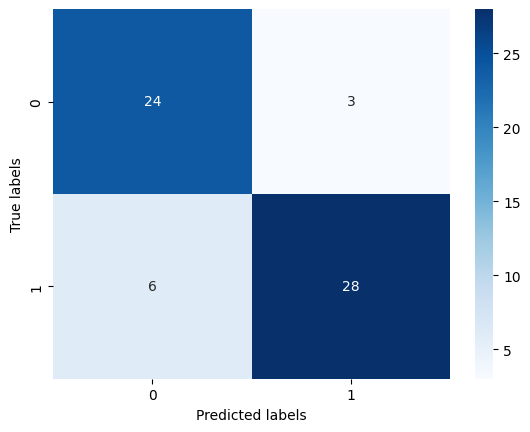

In [57]:
#test the model with the best hyperparameters
y_pred = logreg.predict(X_test)
#plot the confusion matrix 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()



In [58]:
# Generate a classification report
cls_report = classification_report(y_test, y_pred)
print(cls_report)

              precision    recall  f1-score   support

           0       0.80      0.89      0.84        27
           1       0.90      0.82      0.86        34

    accuracy                           0.85        61
   macro avg       0.85      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61



# Hand Model

In [59]:
logreg = LogisticRegression(penalty='l2', C=1.0, random_state=42, solver='liblinear')

# Train the model
logreg.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = logreg.predict(X_test)

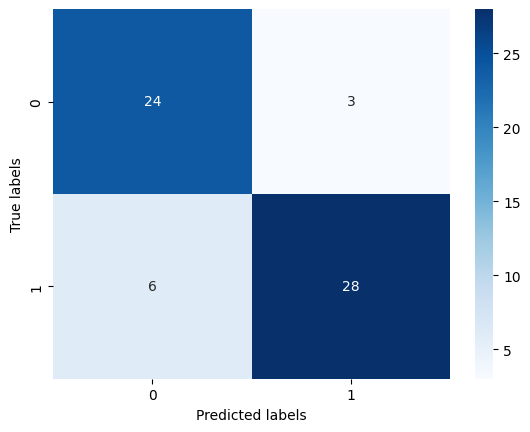

In [60]:
#plot the confusion matrix 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [61]:
# Generate a classification report
cls_report = classification_report(y_test, y_pred)
print(cls_report)

              precision    recall  f1-score   support

           0       0.80      0.89      0.84        27
           1       0.90      0.82      0.86        34

    accuracy                           0.85        61
   macro avg       0.85      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61

